# Prediction of turtle sex with Machine Learning

What machine learning algorithms do is - in principle - very simple: they are fed with data, that they use to define a *decision surface*, mainly used to cluster or tag new/unknown data. We're going to use turtle shells metrics to try and predict turtles sex.

**Supervised** algorithms make use of labelled data, **unsupervised** ones try to cluster the data by the means of mathematics and distance parameters.

To start scratching the surface, I recommend the following Udemy's course:
https://classroom.udacity.com/courses/ud120

### What we will learn

With Python' we'll get to making predictions on actual data, by leveraging Principal Component Analisys (PCA) and Machine Learning (ML) algorithms.

This is a very tiny dataset, but comes from real data, it's handy to work with and it is as good as any as a starter for learning _sklearn_ syntax.

Explanation of the inner clockwork of each ML algorithm as well as algorithm comparison is beyond the scope of this notebook.

### Prerequisites
The PCA data walkthrough can be found at:
https://github.com/Stemanz/python_tutorials/tree/master/PCA

In [126]:
import pandas as pd
import numpy as np

# plotting
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

sep = "\t"

While already discussed, we're loading and PCA-transforming our real-world dataset from scratch:

In [127]:
# ===========================================================
# prepping the data with PCA. Full walkthrough:
# https://github.com/Stemanz/python_tutorials/tree/master/PCA
# ===========================================================
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# load data
df = pd.read_csv("turtles.csv", sep=sep)

# scale data
features = ["length", "width", "height"]
x = df.loc[:, features].values
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore") # int64 to float64 warning suppression
    x = StandardScaler().fit_transform(x)
    dfx = pd.DataFrame(x, columns=features) # back to a dataframe

# PCA dimensionality reduction: 3 to 2
pca = PCA(n_components=2, whiten=True)
PC = pca.fit_transform(x)
dfPC = pd.DataFrame(PC, columns=["PC1", "PC2"])
dfPC["Sex"] = df["Sex"] # retrieving sex info

# the dataset is now ready!

## Supervised Learning

### Dataset splitting into training and testing

To compare a few ML algorithms, we're going to split our dataset in two: we'll be using 75% of  our entries to *train* the algorithm, that will subsequently try and predict the labels of our data.

In [128]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(dfPC, test_size=.25)

test.head()

,PC1,PC2,Sex
38,-0.458235,-1.088213,M
13,0.501055,0.506282,F
12,0.457949,0.767217,F
42,-0.245810,-1.664088,M
47,0.477846,-2.425048,M


*train_test_split* spits back the same _type_ of container it was fed with, so we get back a DataFrame. We now have to transform data according to what _sklearn_ expects, that is:
- data as [[float64, float64], ...] array
- numerical labels

To get the job done quickly, it is better to write down a function that gives back all the stuff we want organized the way we want it.

In [129]:
def split_dataset(df, labels={"M": 0, "F": 1}, test_size=.25):
    """
    This functions works with turtle dataset csv. It splits the dataset into
    train and test data and labels.
    M is sex 0, F is sex 1
    
    Returns:
    train_data, train_labels, test_data, test_labels
    """
    train, test = train_test_split(dfPC, test_size=test_size, random_state=123456)
    
    # using np.reshape to construct the numpy array.
    train_data = np.array(np.reshape(train.iloc[:, [0,1]], (train.shape[0],2)))
    test_data  = np.array(np.reshape(test.iloc[:, [0,1]], (test.shape[0],2)))
    
    # for more complicated label conversions pass custom dict
    train_labels = [labels.get(x) for x in train["Sex"]]
    test_labels  = [labels.get(x) for x in test["Sex"]]
    
    return train_data, train_labels, test_data, test_labels

In [130]:
train_data, train_labels, test_data, test_labels = split_dataset(dfPC)

Now the data is arranged how *sklearn* wants. Here's what train data and labels look like now:

In [131]:
train_data[:5]

array([[-1.15773848,  0.80754832],
       [ 0.41858888,  0.88961967],
       [ 1.83308617,  1.00956637],
       [-0.82921809,  0.28526912],
       [-0.68077941, -0.40473887]])

In [132]:
train_labels[:5]

[1, 1, 1, 1, 0]

### Naïve Bayes

In [133]:
from sklearn.naive_bayes import GaussianNB # NB stands for Naïve Bayes

# training
clf = GaussianNB()
clf.fit(train_data, train_labels)

# predicting
pred_labels = clf.predict(test_data)

Conveniently, different ML algorithms do have the same syntax. The class is instantiated by calling it (with or withour parameters), then it is fitted with **.fit()**.
Predictions are made via **.predict()**.

If the array is conveniently shaped, it is possible to batch-predict stuff. Also individual points can be predicted, for instance:

In [134]:
clf.predict([[ 0.02736815,  2.47830153]]) # note the double square brackets

array([1])

It is crucial to determine the accuracy of the model. _sklearn_ provides a tool that is cross-algorithm.

In [135]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(pred_labels, test_labels)
print(acc)

0.9166666666666666


Without any help and by just using real world measures and labels, the trained algorithm was able to correctly predict the sex of 91% unknown samples. Not a bad thing!

Let's visualize it:

In [144]:
# I'm converting back to a dataframe the arrays.
# Also, I am giving a large numerical value where predictions DO NOT match input data
results = pd.DataFrame(test_data, columns=["PC1", "PC2"])
results["Sex"] = ["M" if x == 0 else "F" for x in test_labels]
results["Match"] = [20 if x == y else 50 for x,y in zip(test_labels, pred_labels)]

traindata = pd.DataFrame(train_data, columns=["PC1", "PC2"])
traindata["Sex"] = ["M" if x == 0 else "F" for x in train_labels]
traindata["Match"] = [1 for _ in range(traindata.shape[0])]

res = pd.concat([results, traindata])

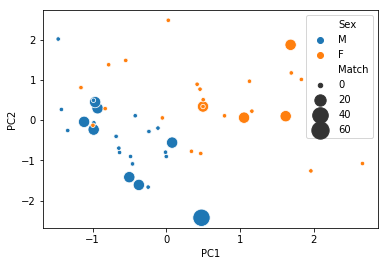

In [145]:
ax = sns.scatterplot(data=res, x="PC1", y="PC2", hue="Sex", size="Match", sizes=(20,300))

This plot shows the training dataset as tiny spots. Larger spots are the ones that have been used as test and correctly predicted. The biggest ones are the ones whose prediction does not match the labels.
As the dataset is split randomly each time, results and predictions may vary.


It looks like the algorithm misdiagnosed that large male in the middle of the plot as a female: anyway, it would have been tough even for a human!

In [150]:
# let's see where test and predicted labels differ

print("Point", "Truth", "Pred", "Match", sep=sep)
for i, elems in enumerate(zip(
    ["M" if x == 0 else "F" for x in test_labels],
    ["M" if x == 0 else "F" for x in pred_labels]
)):
    t, p = elems
    if t != p:
        error = "MISPREDICTION!"
    else:
        error = ""
        
    print(i, t, p, error, sep=sep)

Point	Truth	Pred	Match
0	M	M	
1	M	M	
2	F	F	
3	F	F	
4	M	M	
5	M	M	
6	M	F	MISPREDICTION!
7	M	M	
8	F	F	
9	M	M	
10	F	F	
11	M	M	
